# Best Prediction So Far

In [12]:
# Drug Solubility Predictor
# Import Libraries

import pandas as pd #pandas is a dataframes library 
import numpy as np #numpy provides n-dim object support
import matplotlib.pyplot as plt #plots data
import os
import sklearn 
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
from sqlalchemy.engine import create_engine
logisticRegr = LogisticRegression()
%matplotlib inline

In [13]:
# Import training and test data sets

training_csv = pd.read_csv('C:\Users\joe\Downloads\training_full_set.csv')
test_csv = pd.read_csv('C:/Users/joe/test_full_set.csv')


In [14]:
# Insert log S into test csv with values so it is not removed when concatenated

test_csv['Log_S'] = 111

In [15]:
training_csv.head()

,NAME,Log_S,MW,AMW,Sv,Se,Sp,Si,Mv,Me,...,Psychotic-80,Psychotic-50,Hypertens-80,Hypertens-50,Hypnotic-80,Hypnotic-50,Neoplastic-80,Neoplastic-50,Infective-80,Infective-50
0,1_naphthol,4.018380,144.18,7.588,12.822,18.862,13.500,20.870,0.675,0.993,...,0,0,0,0,0,0,0,0,0,0
1,2_amino_5_bromobenzoic_acid,2.925669,216.04,12.708,12.057,17.636,12.551,19.004,0.709,1.037,...,0,0,0,0,0,0,0,0,1,0
2,4_iodophenol,4.285827,220.01,16.924,9.612,13.047,11.398,14.176,0.739,1.004,...,0,0,0,0,0,0,0,0,0,0
3,5_bromo_2_4_dihydroxybenzoic_acid,3.379708,233.02,13.707,12.465,18.189,12.455,18.925,0.733,1.070,...,0,0,0,0,0,0,0,0,0,0
4,acetaminophen,4.936160,151.18,7.559,12.558,20.291,12.960,22.578,0.628,1.015,...,0,0,0,0,0,0,0,0,0,0


In [16]:
test_csv.head()

,NAME,MW,AMW,Sv,Se,Sp,Si,Mv,Me,Mp,...,Psychotic-50,Hypertens-80,Hypertens-50,Hypnotic-80,Hypnotic-50,Neoplastic-80,Neoplastic-50,Infective-80,Infective-52,Log_S
0,Acebutolol,336.48,6.471,29.750,52.000,31.728,59.232,0.572,1.000,0.610,...,0,1,1,0,0,1,1,1,0,111
1,Amoxicillin,365.45,8.306,28.040,45.087,29.029,49.784,0.637,1.025,0.660,...,0,1,0,0,0,1,1,1,0,111
2,Bendroflumethiazide,421.46,10.280,28.135,43.491,28.273,47.098,0.686,1.061,0.690,...,0,1,1,0,0,1,0,1,0,111
3,Benzocaine,165.21,7.183,14.085,23.174,14.722,25.993,0.612,1.008,0.640,...,0,0,0,1,0,0,0,1,0,111
4,Benzthiazide,431.98,10.799,28.473,41.469,30.205,44.528,0.712,1.037,0.755,...,0,1,1,0,0,1,0,1,0,111


In [17]:
# Concat the two data sets into one taking all columns from both data sets even if there is no value
# Remove the columns that are present in one data set not the other,n.b. this includes log s fixed in In[3]

df = pd.concat((training_csv, test_csv),join='outer',axis=0, ignore_index=True) 
df = df.dropna(axis=1, how='any')
df.shape

(106, 3753)

In [18]:
# Setting colum to name, target column to Log S
# Need to remove null colunms from data frame before doing this step?
# Predicting solubility = y value, everything else = x
ID_col = ['NAME']
target_col = ['Log_S']
num_cols= list(set(list(df.columns))-set(ID_col)-set(target_col))
x = df.loc[:,num_cols].values
y = df.loc[:,['Log_S']].values
df.NAME.head()

0                           1_naphthol
1          2_amino_5_bromobenzoic_acid
2                         4_iodophenol
3    5_bromo_2_4_dihydroxybenzoic_acid
4                        acetaminophen
Name: NAME, dtype: object

In [19]:
df.isnull().values.any()
False
# At this point we have a data frame with training and test data with
# Matching columns and test data with arbitrary Log S values (111)

False

In [20]:
df.loc[:,"TPSA(Tot)"].head()

0    20.23
1    63.32
2    20.23
3    77.76
4    49.33
Name: TPSA(Tot), dtype: float64

In [24]:
# This is counting the number of values in the dataframe for the TPSA(Tot) Column
df.loc[:,"TPSA(Tot)"].count()

106

In [31]:
# Count number of nulls. Sanity check that both sets have this present after concat
# Already did this in [19]
df.loc[:,"ALOGP"].isnull().sum()

0

In [33]:
# Trying out creating a smaller data frame for a better PLSR
newdf = df[['NAME', 'Log_S', 'MW']].copy()

In [34]:
newdf.head()

,NAME,Log_S,MW
0,1_naphthol,4.018380,144.18
1,2_amino_5_bromobenzoic_acid,2.925669,216.04
2,4_iodophenol,4.285827,220.01
3,5_bromo_2_4_dihydroxybenzoic_acid,3.379708,233.02
4,acetaminophen,4.936160,151.18


In [40]:
# Reindex to 'NAME'
newdf.set_index('NAME')

,Log_S,MW
NAME,,
1_naphthol,4.018380,144.18
2_amino_5_bromobenzoic_acid,2.925669,216.04
4_iodophenol,4.285827,220.01
5_bromo_2_4_dihydroxybenzoic_acid,3.379708,233.02
acetaminophen,4.936160,151.18
acetazolamide,3.564820,222.28
alprenolol,3.365842,249.39
amantadine,4.146361,151.28
amitryptyline,1.450392,277.44


In [41]:
# Create new smaller dataframe to do PLSR and try and get a better fit. Using 10 Descriptors
# Number of observations > 3^(number of descriptors)
# Number of observations > 5 x (number of descriptors)
# Training Set Observtion = 74
# 74 > 5 x 14 & 74 >

smalldf = df[['NAME', 'Log_S', 'MW', 'Sv', 'Si', 'Hy', 'MLOGP', 'TPSA(Tot)']].copy()

In [42]:
smalldf.head()

,NAME,Log_S,MW,Sv,Si,Hy,MLOGP,TPSA(Tot)
0,1_naphthol,4.018380,144.18,12.822,20.870,-0.294,2.637,20.23
1,2_amino_5_bromobenzoic_acid,2.925669,216.04,12.057,19.004,1.661,2.405,63.32
2,4_iodophenol,4.285827,220.01,9.612,14.176,-0.039,2.461,20.23
3,5_bromo_2_4_dihydroxybenzoic_acid,3.379708,233.02,12.465,18.925,1.636,1.865,77.76
4,acetaminophen,4.936160,151.18,12.558,22.578,0.660,1.060,49.33


In [43]:
smalldf.set_index('NAME')

,Log_S,MW,Sv,Si,Hy,MLOGP,TPSA(Tot)
NAME,,,,,,,
1_naphthol,4.018380,144.18,12.822,20.870,-0.294,2.637,20.23
2_amino_5_bromobenzoic_acid,2.925669,216.04,12.057,19.004,1.661,2.405,63.32
4_iodophenol,4.285827,220.01,9.612,14.176,-0.039,2.461,20.23
5_bromo_2_4_dihydroxybenzoic_acid,3.379708,233.02,12.465,18.925,1.636,1.865,77.76
acetaminophen,4.936160,151.18,12.558,22.578,0.660,1.060,49.33
acetazolamide,3.564820,222.28,13.131,21.877,1.837,-1.583,151.66
alprenolol,3.365842,249.39,23.246,46.484,0.320,2.370,41.49
amantadine,4.146361,151.28,15.236,31.820,0.485,2.502,26.02
amitryptyline,1.450392,277.44,26.816,49.066,-0.938,4.761,3.24


In [44]:
# seperate out the data frame into training and test again. currently have n number of records with log s =111
# need to seperate them into training and test again to generate model 
test_df = smalldf[df.Log_S == 111]
train_df = smalldf[df.Log_S < 111]

In [45]:
train_df.count()

NAME         74
Log_S        74
MW           74
Sv           74
Si           74
Hy           74
MLOGP        74
TPSA(Tot)    74
dtype: int64

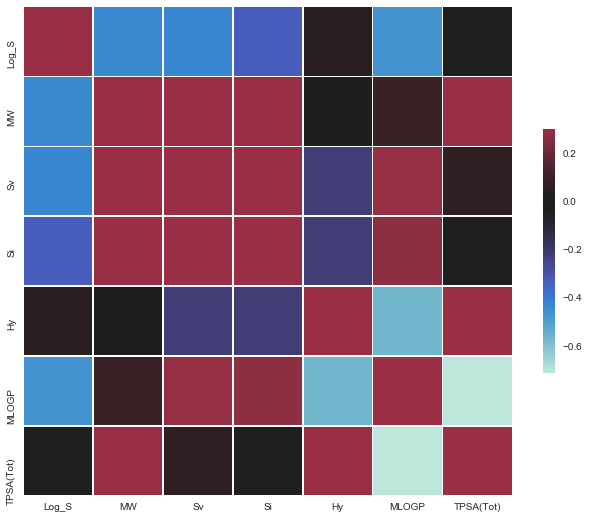

In [61]:
sns.set(style="white")
# Compute the correlation matrix
corr = train_df.corr()
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [78]:
# create values for an array to use as input for logistic regression function
ID_col = ['NAME']
target_col = ['Log_S']
num_cols = list(set(list(train_df.columns))-set(ID_col)-set(target_col))
num_cols2 = list(set(list(test_df.columns))-set(ID_col)-set(target_col))
train_x = train_df.loc[:,num_cols].values
train_y = train_df.loc[:,['Log_S']].values
test_x = test_df.loc[:,num_cols2].values
test_y = test_df.loc[:,['Log_S']].values

In [79]:
# Scale data mean centre and unit varience 
scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x, train_y)
test_x_scaled = scaler.fit_transform(test_x, test_y)

In [87]:
PLSR = PLSRegression(n_components=6)
PLSR.fit(train_x_scaled, train_y)

PLSRegression(copy=True, max_iter=500, n_components=6, scale=True, tol=1e-06)

In [88]:
# Prediction 
Y_predict = PLSR.predict(test_x_scaled)

In [89]:
print(Y_predict)

[[3.16559837]
 [2.29889364]
 [1.99702691]
 [3.7309141 ]
 [1.54511311]
 [3.64658228]
 [2.27587393]
 [2.52404432]
 [1.77751412]
 [1.72837451]
 [2.12271468]
 [4.06300309]
 [0.73667533]
 [2.77806848]
 [3.70904083]
 [2.43194016]
 [1.53512605]
 [2.0947104 ]
 [3.63936095]
 [3.19122374]
 [1.52577137]
 [2.94569345]
 [4.06300309]
 [3.44636458]
 [1.89121617]
 [3.72408239]
 [3.257401  ]
 [3.21120654]
 [0.3134833 ]
 [3.33443129]
 [3.60981093]
 [2.05510015]]


In [1]:
# Evaluate Model
score = r2_score(train_y, test_y)

NameError: name 'r2_score' is not defined